In [1]:
from qiskit import __version__
print(__version__)

1.1.1


In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector, state_fidelity, Pauli, DensityMatrix
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit import transpile 
import numpy as np
from qiskit_aer.noise import NoiseModel, depolarizing_error, ReadoutError, pauli_error 
from qiskit.circuit.library import HGate, UnitaryGate, CXGate
import matplotlib.pyplot as plt

In [2]:
from steane_ec_decoder import bool_syndrome_flag, syndrome

# Encoding Circuit

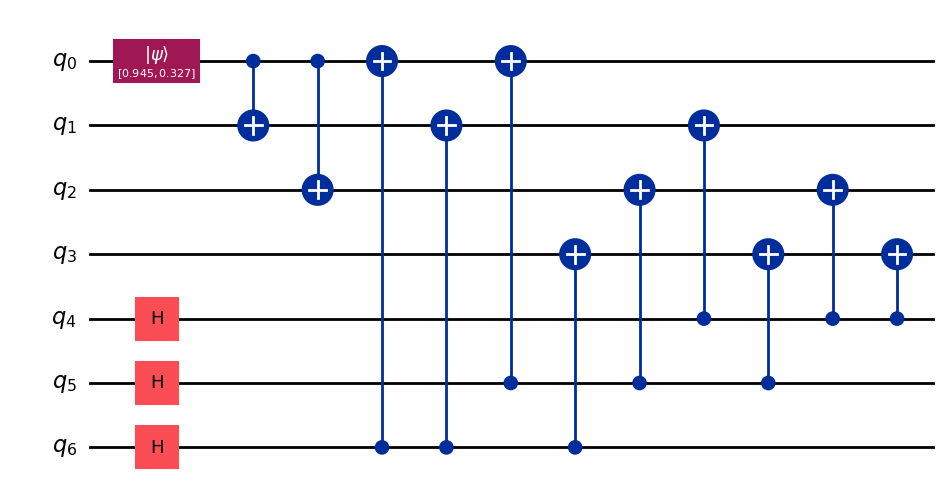

In [3]:
encoding = QuantumCircuit(7)

theta = np.arctan(np.sqrt((np.sqrt(5) - 1) / 2))
amp_0 = np.cos(theta/2)
amp_1 = np.sin(theta/2)

encoding.initialize([amp_0, amp_1], 0)

for i in range(4, 7):
    encoding.h(i)

encoding.cx(0, 1)
encoding.cx(0, 2)
encoding.cx(6, 0)
encoding.cx(6, 1)
encoding.cx(6, 3)
encoding.cx(5, 0)
encoding.cx(5, 2)
encoding.cx(5, 3)
encoding.cx(4, 1)
encoding.cx(4, 2)
encoding.cx(4, 3)

display(encoding.draw(output='mpl'))

# Syndrome Extraction Circuit without Flag

In [4]:
se_nf = QuantumCircuit(23, 16)
# First 7 qubits are data qubits in the logical |\psi> state
# Next 8 are prepared in the logical |+> state
# Last 8 are prepared in the logical |0> state

# Encoding first 7 qubits, 0-6
theta = np.arctan(np.sqrt((np.sqrt(5) - 1) / 2))
amp_0 = np.cos(theta/2)
amp_1 = np.sin(theta/2)

se_nf.initialize([amp_0, amp_1], 0)
for i in range(4, 7):
    se_nf.h(i)
se_nf.cx(0, 1)
se_nf.cx(0, 2)
se_nf.cx(6, 0)
se_nf.cx(6, 1)
se_nf.cx(6, 3)
se_nf.cx(5, 0)
se_nf.cx(5, 2)
se_nf.cx(5, 3)
se_nf.cx(4, 1)
se_nf.cx(4, 2)
se_nf.cx(4, 3)
se_nf.barrier()

# Encoding next 8 qubits, 7-14
se_nf.h(7)
se_nf.h(8)
se_nf.h(10)
se_nf.cx(7, 11)
se_nf.cx(8, 9)
se_nf.cx(10, 12)
se_nf.cx(7, 13)
se_nf.cx(10, 11)
se_nf.cx(8, 12)
se_nf.cx(7, 9)
se_nf.cx(12, 13)
se_nf.cx(11, 14)
se_nf.cx(9, 14)
se_nf.cx(12, 14)
se_nf.measure([14], [0]) # Post-select for 0
for i in range(7, 14):
    se_nf.h(i)
se_nf.barrier()

# Encoding last 8 qubits, 15-22
se_nf.h(15)
se_nf.h(16)
se_nf.h(18)
se_nf.cx(15, 19)
se_nf.cx(16, 17)
se_nf.cx(18, 20)
se_nf.cx(15, 21)
se_nf.cx(18, 19)
se_nf.cx(16, 20)
se_nf.cx(15, 17)
se_nf.cx(20, 21)
se_nf.cx(19, 22)
se_nf.cx(17, 22)
se_nf.cx(20, 22)
se_nf.measure([22], [1]) # Post-select for 0
se_nf.barrier()
    
# Transversal CNOTs from data qubits to next 7 qubits and measure syndrome
for i in range(7):
    se_nf.cx(i, i+7)
for i in range(7):
    se_nf.measure([i+7], [i+2])
se_nf.barrier()

# Transversal CNOTs from last 7 qubits to data qubits and measure syndrome
for i in range(7):
    se_nf.cx(i+15, i)
for i in range(15, 22):
    se_nf.h(i)
for i in range(7):
    se_nf.measure([i+15], [i+9])
    
#display(se_nf.draw("mpl"))

# Syndrome Extraction Circuit with Flag

In [5]:
se_wf = QuantumCircuit(13, 6)
# First 7 qubits are encoding in the logical |psi> state
# Next 6 qubits are ancillas

# Encoding first 7 qubits, 0-6
theta = np.arctan(np.sqrt((np.sqrt(5) - 1) / 2))
amp_0 = np.cos(theta/2)
amp_1 = np.sin(theta/2)

se_wf.initialize([amp_0, amp_1], 0)
for i in range(4, 7):
    se_wf.h(i)
se_wf.cx(0, 1)
se_wf.cx(0, 2)
se_wf.cx(6, 0)
se_wf.cx(6, 1)
se_wf.cx(6, 3)
se_wf.cx(5, 0)
se_wf.cx(5, 2)
se_wf.cx(5, 3)
se_wf.cx(4, 1)
se_wf.cx(4, 2)
se_wf.cx(4, 3)
se_wf.barrier()

# Encoding next 6 qubits and applying CNOTs and measurements, 7-12
se_wf.h(7)
se_wf.h(11)
se_wf.h(12)
se_wf.cx(7, 4)
se_wf.cx(6, 8)
se_wf.cx(5, 9)
se_wf.cx(7, 9)
se_wf.cx(7, 0)
se_wf.cx(4, 8)
se_wf.cx(1, 9)
se_wf.cx(7, 2)
se_wf.cx(3, 8)
se_wf.cx(6, 9)
se_wf.cx(7, 8)
se_wf.cx(7, 6)
se_wf.cx(5, 8)
se_wf.cx(2, 9)
se_wf.cx(4, 10)
se_wf.cx(11, 6)
se_wf.cx(12, 5)
se_wf.cx(12, 10)
se_wf.cx(0, 10)
se_wf.cx(11, 4)
se_wf.cx(12, 1)
se_wf.cx(2, 10)
se_wf.cx(11, 3)
se_wf.cx(12, 6)
se_wf.cx(11, 10)
se_wf.cx(6, 10)
se_wf.cx(11, 5)
se_wf.cx(12, 2)

se_wf.h(7)
se_wf.h(11)
se_wf.h(12)
for i in range(6):
    se_wf.measure([i+7], [i])
    
#display(se_wf.draw('mpl'))

# Logical Error Rate for Encoding Circuit

In [6]:
logical_error_circ = QuantumCircuit(29, 22)
# First 7 qubits are data qubits
# Next 6 qubits are for syndrome extraction with flag
# Next 16 qubits are for syndrome extractino without flag

logical_error_circ.initialize([amp_0, amp_1], 0)

for i in range(7):
    logical_error_circ.id(i)

for i in range(4, 7):
    logical_error_circ.h(i)

logical_error_circ.cx(0, 1)
logical_error_circ.cx(0, 2)
logical_error_circ.cx(6, 0)
logical_error_circ.cx(6, 1)
logical_error_circ.cx(6, 3)
logical_error_circ.cx(5, 0)
logical_error_circ.cx(5, 2)
logical_error_circ.cx(5, 3)
logical_error_circ.cx(4, 1)
logical_error_circ.cx(4, 2)
logical_error_circ.cx(4, 3)

In [7]:
noise_model = NoiseModel()

noise_model.add_all_qubit_quantum_error(depolarizing_error(0.005,1), ['id'])
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.005,1), ['h'])
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.05,2), ['cx'])

# 5% chance of flipping 0 <-> 1
readout_err = ReadoutError([[0.995, 0.005],  # P(measured 0 | actual 0), P(1 | 0)
                            [0.005, 0.995]]) # P(0 | 1), P(1 | 1)

# Apply to all qubits being measured
noise_model.add_readout_error(readout_err, [7])
noise_model.add_readout_error(readout_err, [8])


meas_circuit_noise = logical_error_circ.copy()
meas_circuit_noise.barrier()

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=29, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(29, 'q'), 0), Qubit(QuantumRegister(29, 'q'), 1), Qubit(QuantumRegister(29, 'q'), 2), Qubit(QuantumRegister(29, 'q'), 3), Qubit(QuantumRegister(29, 'q'), 4), Qubit(QuantumRegister(29, 'q'), 5), Qubit(QuantumRegister(29, 'q'), 6), Qubit(QuantumRegister(29, 'q'), 7), Qubit(QuantumRegister(29, 'q'), 8), Qubit(QuantumRegister(29, 'q'), 9), Qubit(QuantumRegister(29, 'q'), 10), Qubit(QuantumRegister(29, 'q'), 11), Qubit(QuantumRegister(29, 'q'), 12), Qubit(QuantumRegister(29, 'q'), 13), Qubit(QuantumRegister(29, 'q'), 14), Qubit(QuantumRegister(29, 'q'), 15), Qubit(QuantumRegister(29, 'q'), 16), Qubit(QuantumRegister(29, 'q'), 17), Qubit(QuantumRegister(29, 'q'), 18), Qubit(QuantumRegister(29, 'q'), 19), Qubit(QuantumRegister(29, 'q'), 20), Qubit(QuantumRegister(29, 'q'), 21), Qubit(QuantumRegister(29, 'q'), 22), Qubit(QuantumRegister(29, 'q'), 23), Qubit(QuantumReg

In [ ]:
# Syndrome measurement using flag
for i in range(4, 7):
    meas_circuit_noise.h(i)
meas_circuit_noise.cx(0, 1)
meas_circuit_noise.cx(0, 2)
meas_circuit_noise.cx(6, 0)
meas_circuit_noise.cx(6, 1)
meas_circuit_noise.cx(6, 3)
meas_circuit_noise.cx(5, 0)
meas_circuit_noise.cx(5, 2)
meas_circuit_noise.cx(5, 3)
meas_circuit_noise.cx(4, 1)
meas_circuit_noise.cx(4, 2)
meas_circuit_noise.cx(4, 3)
meas_circuit_noise.barrier()

# Encoding next 6 qubits and applying CNOTs and measurements, 7-12
meas_circuit_noise.h(7)
meas_circuit_noise.h(11)
meas_circuit_noise.h(12)
meas_circuit_noise.cx(7, 4)
meas_circuit_noise.cx(6, 8)
meas_circuit_noise.cx(5, 9)
meas_circuit_noise.cx(7, 9)
meas_circuit_noise.cx(7, 0)
meas_circuit_noise.cx(4, 8)
meas_circuit_noise.cx(1, 9)
meas_circuit_noise.cx(7, 2)
meas_circuit_noise.cx(3, 8)
meas_circuit_noise.cx(6, 9)
meas_circuit_noise.cx(7, 8)
meas_circuit_noise.cx(7, 6)
meas_circuit_noise.cx(5, 8)
meas_circuit_noise.cx(2, 9)
meas_circuit_noise.cx(4, 10)
meas_circuit_noise.cx(11, 6)
meas_circuit_noise.cx(12, 5)
meas_circuit_noise.cx(12, 10)
meas_circuit_noise.cx(0, 10)
meas_circuit_noise.cx(11, 4)
meas_circuit_noise.cx(12, 1)
meas_circuit_noise.cx(2, 10)
meas_circuit_noise.cx(11, 3)
meas_circuit_noise.cx(12, 6)
meas_circuit_noise.cx(11, 10)
meas_circuit_noise.cx(6, 10)
meas_circuit_noise.cx(11, 5)
meas_circuit_noise.cx(12, 2)

meas_circuit_noise.h(7)
meas_circuit_noise.h(11)
meas_circuit_noise.h(12)
for i in range(6):
    meas_circuit_noise.measure([i+7], [i])
    
#############################################

# Encoding next 8 qubits, 13-20
meas_circuit_noise.h(13)
meas_circuit_noise.h(14)
meas_circuit_noise.h(16)
meas_circuit_noise.cx(13, 17)
meas_circuit_noise.cx(14, 15)
meas_circuit_noise.cx(16, 18)
meas_circuit_noise.cx(13, 19)
meas_circuit_noise.cx(16, 17)
meas_circuit_noise.cx(14, 18)
meas_circuit_noise.cx(13, 15)
meas_circuit_noise.cx(18, 19)
meas_circuit_noise.cx(17, 20)
meas_circuit_noise.cx(15, 20)
meas_circuit_noise.cx(18, 20)
meas_circuit_noise.measure([20], [6]) # Post-select for 0
for i in range(13, 20):
    meas_circuit_noise.h(i)
meas_circuit_noise.barrier()

# Encoding last 8 qubits, 21-28
meas_circuit_noise.h(21)
meas_circuit_noise.h(22)
meas_circuit_noise.h(24)
meas_circuit_noise.cx(21, 25)
meas_circuit_noise.cx(22, 23)
meas_circuit_noise.cx(24, 26)
meas_circuit_noise.cx(21, 27)
meas_circuit_noise.cx(24, 25)
meas_circuit_noise.cx(22, 26)
meas_circuit_noise.cx(21, 23)
meas_circuit_noise.cx(26, 27)
meas_circuit_noise.cx(25, 28)
meas_circuit_noise.cx(23, 28)
meas_circuit_noise.cx(26, 28)
meas_circuit_noise.measure([28], [7]) # Post-select for 0
meas_circuit_noise.barrier()
    
# Transversal CNOTs from data qubits to next 7 qubits and measure syndrome
for i in range(7):
    meas_circuit_noise.cx(i, i+13)
for i in range(7):
    meas_circuit_noise.measure([i+13], [i+8])
meas_circuit_noise.barrier()

# Transversal CNOTs from last 7 qubits to data qubits and measure syndrome
for i in range(7):
    meas_circuit_noise.cx(i+21, i)
for i in range(21, 28):
    meas_circuit_noise.h(i)
for i in range(7):
    meas_circuit_noise.measure([i+21], [i+15])

backend = AerSimulator(noise_model=noise_model, method='matrix_product_state')
transpiled = transpile(meas_circuit_noise, backend, optimization_level=0)
job = backend.run(transpiled, shots=1, memory=True)
result = job.result()

# Extracting the syndromes
memory = result.get_memory()[0]
flag_syndrome = memory[-6:]
flag_syndrome = flag_syndrome[::-1]
flag_syndrome = [int (b) for b in flag_syndrome]

indices_z = [3, 1, 2]
syndrome_flag_z = [flag_syndrome[i] for i in indices_z]

indices_x = [0, 4, 5]
syndrome_flag_x = [flag_syndrome[i] for i in indices_x]

print(memory)
print(flag_syndrome)
print(syndrome_flag_z)
print(syndrome_flag_x)

In [ ]:
# Extracting the second no flag syndrome (double check if this is valid)
no_flag_syndrome_2 = memory[-14:-7]
no_flag_syndrome_2 = no_flag_syndrome_2[::-1]
no_flag_syndrome_2 = [int (b) for b in no_flag_syndrome_2]

indices_z = [3, 1, 2]
syndrome_no_flag_2_z = [no_flag_syndrome_2[i] for i in indices_z]

indices_x = [0, 4, 5]
syndrome_no_flag_2_x= [no_flag_syndrome_2[i] for i in indices_x]

print(memory)
print(no_flag_syndrome_2)
print(syndrome_no_flag_2_z )
print(syndrome_no_flag_2_x)

In [ ]:
# Extracting the first no flag syndrome (double check if this is valid)
no_flag_syndrome_1 = memory[-21:-15]
no_flag_syndrome_1 = no_flag_syndrome_1[::-1]
no_flag_syndrome_1 = [int (b) for b in no_flag_syndrome_1]

indices_z = [3, 1, 2]
syndrome_no_flag_1_z = [no_flag_syndrome_1[i] for i in indices_z]

indices_x = [0, 4, 5]
syndrome_no_flag_1_x= [no_flag_syndrome_1[i] for i in indices_x]

print(memory)
print(no_flag_syndrome_1)
print(syndrome_no_flag_1_z )
print(syndrome_no_flag_1_x)

In [ ]:
from helper_functions_for_enc_logical import get_noise_list, get_logical_error_circ, get_meas_circuit_noise
import pandas as pd
from pandas import DataFrame

In [ ]:
err_list_size = 20
error_list = np.logspace((-3), (-2), err_list_size)
noise_sweep_type = "depolarizing"

logical_df = pd.DataFrame(columns= error_list)
logical_depolarizing_df = pd.DataFrame(columns= error_list)

logical_depolarizing_df["noise_sweep_type"] = noise_sweep_type


In [ ]:

err_list_size = 20
error_list = np.logspace((-3), (-2), err_list_size)
noise_sweep_type = "depolarizing"

noise_list = get_noise_list(noise_sweep_type, error_list, err_list_size)

logical_depolarizing_df["noise_models"] = noise_list

memory_list = []
flag_syndrome_list = []
syndrome_flag_z = []
syndrome_flag_x = []
for noise_model in noise_list:
    backend = AerSimulator(noise_model=noise_model, method='matrix_product_state')
    transpiled = transpile(meas_circuit_noise, backend, optimization_level=0)
    job = backend.run(transpiled, shots=1, memory=True)
    result = job.result()

    # Extracting the syndromes
    memory = result.get_memory()[0]
    flag_syndrome = memory[-6:]
    flag_syndrome = flag_syndrome[::-1]
    flag_syndrome = [int (b) for b in flag_syndrome]

    indices_z = [3, 1, 2]
    syndrome_flag_z = [flag_syndrome[i] for i in indices_z]

    indices_x = [0, 4, 5]
    syndrome_flag_x = [flag_syndrome[i] for i in indices_x]

    print(memory)
    print(flag_syndrome)
    print(syndrome_flag_z)
    print(syndrome_flag_x)

logical_depolarizing_df['memory_list'] = memory_list
logical_depolarizing_df['flag_syndrome_list'] = flag_syndrome_list
logical_depolarizing_df['syndrome_flag_z'] = syndrome_flag_z 
logical_depolarizing_df['syndrome_flag_x'] = syndrome_flag_x 

logical_depolarizing_df.to_csv("encoding_logical_error_rate_depolarizing_results")




In [ ]:

err_list_size = 20
error_list = np.logspace((-3), (-2), err_list_size)
noise_sweep_type = "pauli"

logical_pauli_df = pd.DataFrame(columns= error_list)
logical_pauli_df["noise_sweep_type"] = noise_sweep_type

noise_list = get_noise_list(noise_sweep_type, error_list, err_list_size)




memory_list = []
flag_syndrome_list = []
syndrome_flag_z = []
syndrome_flag_x = []
for noise_model in noise_list:
    backend = AerSimulator(noise_model=noise_model, method='matrix_product_state')
    transpiled = transpile(meas_circuit_noise, backend, optimization_level=0)
    job = backend.run(transpiled, shots=1, memory=True)
    result = job.result()

    # Extracting the syndromes
    memory = result.get_memory()[0]
    flag_syndrome = memory[-6:]
    flag_syndrome = flag_syndrome[::-1]
    flag_syndrome = [int (b) for b in flag_syndrome]

    indices_z = [3, 1, 2]
    syndrome_flag_z = [flag_syndrome[i] for i in indices_z]

    indices_x = [0, 4, 5]
    syndrome_flag_x = [flag_syndrome[i] for i in indices_x]

    print(memory)
    print(flag_syndrome)
    print(syndrome_flag_z)
    print(syndrome_flag_x)
    
logical_pauli_df['memory_list'] = memory_list
logical_pauli_df['flag_syndrome_list'] = flag_syndrome_list
logical_pauli_df['syndrome_flag_z'] = syndrome_flag_z 
logical_pauli_df['syndrome_flag_x'] = syndrome_flag_x 

logical_pauli_df.to_csv("encoding_logical_error_rate_pauli_results")


In [ ]:
logical_df = pd.concat([logical_depolarizing_df, logical_pauli_df], axis=1) 

logical_df.to_csv("encoding_logical_error_rate_results")
logical_df.display()